# Projet 8 : Déployez un modèle dans le cloud

Import des librairies nécessaires

In [0]:
import os
from pyspark.sql.functions import *
import urllib

import pandas as pd
from PIL import Image
import numpy as np
import io

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType, udf
from pyspark.ml.functions import array_to_vector, vector_to_array

from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors

import seaborn as sns
from matplotlib import pyplot as plt


Authentification et connexion au bucket S3

In [0]:
aws_keys_df = spark.read.format('csv')\
    .option('header','true')\
    .option('sep',',')\
    .load('/FileStore/tables/new_user_credentials.csv')

In [0]:
ACCESS_KEY = aws_keys_df.select('Access key ID').collect()[0]['Access key ID']
SECRET_KEY = aws_keys_df.select('Secret access key').collect()[0]['Secret access key']

ENCODED_SECRET_KEY = urllib.parse.quote(string=SECRET_KEY, safe="")

In [0]:
AWS_S3_BUCKET = 'databricks-workspace-stack-lambdazipsbucket-3gifk1wrsna0'
MOUNT_NAME = '/mnt/databricks-workspace-stack-lambdazipsbucket-3gifk1wrsna0'

SOURCE_URL = "s3n://{0}:{1}@{2}".format(ACCESS_KEY,ENCODED_SECRET_KEY,AWS_S3_BUCKET)

dbutils.fs.mount(SOURCE_URL,MOUNT_NAME)

--------------------------------------------------------------------------- 
 ExecutionError Traceback (most recent call last)
 <command-2187946846714520> in <module> 
 4 SOURCE_URL = "s3n://{0}:{1}@{2}" . format ( ACCESS_KEY , ENCODED_SECRET_KEY , AWS_S3_BUCKET ) 
 5 
 ----> 6 dbutils . fs . mount ( SOURCE_URL , MOUNT_NAME ) 

 /databricks/python_shell/dbruntime/dbutils.py in f_with_exception_handling (*args, **kwargs) 
 379 exc . __context__ = None 
 380 exc . __cause__ = None 
 --> 381 raise exc
 382 
 383 return f_with_exception_handling

 ExecutionError : An error occurred while calling o323.mount.
: java.rmi.RemoteException: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/databricks-workspace-stack-lambdazipsbucket-3gifk1wrsna0; nested exception is: 
	java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/databricks-workspace-stack-lambdazipsbucket-3gifk1wrsna0
	at com.databricks.backend.daemon.data.client.DbfsClient.send0(DbfsClient.scala:128)
	at com.databricks.backend.daemon.data.client.DbfsClient.sendIdempotent(DbfsClient.scala:68)
	at com.databricks.backend.daemon.dbutils.DBUtilsCore.mount(DBUtilsCore.scala:739)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/databricks-workspace-stack-lambdazipsbucket-3gifk1wrsna0
	at scala.Predef$.require(Predef.scala:281)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.$anonfun$insertMount$1(MetadataManager.scala:459)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.$anonfun$modifyAndVerify$1(MetadataManager.scala:824)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.withRetries(MetadataManager.scala:605)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.modifyAndVerify(MetadataManager.scala:813)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.insertMount(MetadataManager.scala:467)
	at com.databricks.backend.daemon.data.server.handler.MountHandler.receive(MountHandler.scala:99)
	at com.databricks.backend.daemon.data.server.session.SessionContext.$anonfun$queryHandlers$1(SessionContext.scala:97)
	at com.databricks.backend.daemon.data.server.session.SessionContext.$anonfun$queryHandlers$1$adapted(SessionContext.scala:96)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at com.databricks.backend.daemon.data.server.session.SessionContext.queryHandlers(SessionContext.scala:96)
	at com.databricks.backend.daemon.data.server.DbfsServerBackend$$anonfun$receive$3.applyOrElse(DbfsServerBackend.scala:300)
	at com.databricks.backend.daemon.data.server.DbfsServerBackend$$anonfun$receive$3.applyOrElse(DbfsServerBackend.scala:259)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$2(ServerBackend.scala:90)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:117)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:117)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$1(ServerBackend.scala:75)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:346)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.sca

Lecture des données

In [0]:
folder_path = '/mnt/databricks-workspace-stack-lambdazipsbucket-3gifk1wrsna0/'
images = spark.read.format('binaryFile') \
    .option('pathGlobFilter','*.jpg') \
    .option('recursiveFileLookup','true') \
    .load(folder_path)

In [0]:
images.limit(5).show()

+--------------------+-------------------+------+--------------------+
 path| modificationTime|length| content|
+--------------------+-------------------+------+--------------------+
dbfs:/mnt/databri...|2022-03-03 11:53:51| 6489|[FF D8 FF E0 00 1...|
dbfs:/mnt/databri...|2022-03-03 11:53:55| 6462|[FF D8 FF E0 00 1...|
dbfs:/mnt/databri...|2022-03-03 11:53:54| 6427|[FF D8 FF E0 00 1...|
dbfs:/mnt/databri...|2022-03-03 11:53:55| 6424|[FF D8 FF E0 00 1...|
dbfs:/mnt/databri...|2022-03-03 11:53:46| 6412|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+

Extraction de la catégorie de fruits / légumes depuis le chemin d'accès au fichier

In [0]:
@udf('string')
def get_category(s: str) -> str:
        path = os.path.normpath(s)
        return path.split(os.sep)[-2]

In [0]:
images = images.select(get_category('path').alias('category'),col('content'))

In [0]:
images.limit(5).show()

+----------+--------------------+
 category| content|
+----------+--------------------+
Watermelon|[FF D8 FF E0 00 1...|
Watermelon|[FF D8 FF E0 00 1...|
Watermelon|[FF D8 FF E0 00 1...|
Watermelon|[FF D8 FF E0 00 1...|
Watermelon|[FF D8 FF E0 00 1...|
+----------+--------------------+

Mise à disposition du modèle resNet à l'ensemble du cluster

In [0]:
# Pour une extraction de features nous n'utilisons pas la dernière couche du modèle
model = ResNet50(include_top=False)
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

Définition des fonctions d'extraction de features

In [0]:
# Fonction permettant de construire le modèle depuis les poids distribués
def model_fn():
 
  model = ResNet50(weights=None, include_top=False)
  model.set_weights(bc_model_weights.value)
  return model

In [0]:
# Transformation de l'image en array utilisable par le modèle
def preprocess(content):
 
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

In [0]:
# Le modèle fournit sa prédiction pour une série de arrays
def featurize_series(model, content_series):

  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  output = [p.flatten() for p in preds]
  return pd.Series(output)

In [0]:
# Les prédictions sont séparées en plusieurs séries afin de distribuer la tâche de prédiction
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter: PandasUDFType.SCALAR_ITER) -> PandasUDFType.SCALAR_ITER :
  
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
 warnings.warn(

Extraction des features

In [0]:
features_df = images.repartition(3) \
    .select(col("category"), featurize_udf("content")) \
    .withColumnRenamed('featurize_udf(content)','features')

Conversion pour analyse et enregistrement des features

In [0]:
features_df = features_df.select(col('category'),array_to_vector('features').alias('features'))

In [0]:
features_df = features_df.select('category','features').cache()

In [0]:
features_df.write.mode('overwrite')\
    .parquet(folder_path+'extracted_features')

Réduction de dimensions des features extraits

In [0]:
pca = PCA(k=2, inputCol='features')
pca.setOutputCol('pca_features')

Out[78]: PCA_5a1da901fe45

In [0]:
model = pca.fit(features_df)

In [0]:
reduced_data = model.transform(features_df)

In [0]:
reduced_data = reduced_data.select('category','pca_features') \
    .withColumn('PC', vector_to_array('pca_features')) \
    .select(['category'] + [col('PC')[i] for i in range(2)])

Enregistrement de la réduction de dimensions

In [0]:
reduction_result.write.parquet(folder_path+'PCA_results')

Visualisation des données par PCA

In [0]:
plot_data = reduced_data.limit(70).toPandas()

In [0]:
plot_data

Out[86]:

,category,PC[0],PC[1]
0,Ginger Root,236.400298,-196.215798
1,Watermelon,34.113082,311.428546
2,corn,-363.683809,-149.772742
3,corn,-359.137841,-138.019969
4,corn,-345.344065,-138.457319
...,...,...,...
65,Watermelon,36.743244,303.672504
66,Watermelon,35.078273,325.016808
67,Ginger Root,234.915564,-204.027669
68,Ginger Root,222.119157,-172.308279


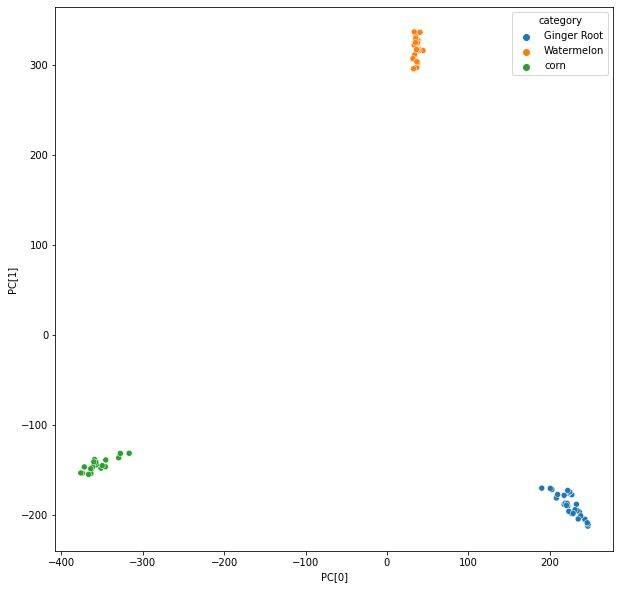

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=plot_data['PC[0]'],
                y= plot_data['PC[1]'],
                hue=plot_data['category']);